In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [2]:
df = pd.read_csv("DataCoSupplyChainDataset.csv", encoding="latin1")
df.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


In [6]:
df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Type                           180519 non-null  object        
 1   Days for shipping (real)       180519 non-null  int64         
 2   Days for shipment (scheduled)  180519 non-null  int64         
 3   Benefit per order              180519 non-null  float64       
 4   Sales per customer             180519 non-null  float64       
 5   Delivery Status                180519 non-null  object        
 6   Late_delivery_risk             180519 non-null  int64         
 7   Category Id                    180519 non-null  int64         
 8   Category Name                  180519 non-null  object        
 9   Customer City                  180519 non-null  object        
 10  Customer Country               180519 non-null  object        
 11  

In [5]:
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])


In [7]:
df['Actual_Shipping_LeadTime'] = (df['shipping date (DateOrders)'] - df['order date (DateOrders)']).dt.days
df[['order date (DateOrders)', 'shipping date (DateOrders)', 'Actual_Shipping_LeadTime']].head()


,order date (DateOrders),shipping date (DateOrders),Actual_Shipping_LeadTime
0,2018-01-31 22:56:00,2018-02-03 22:56:00,3
1,2018-01-13 12:27:00,2018-01-18 12:27:00,5
2,2018-01-13 12:06:00,2018-01-17 12:06:00,4
3,2018-01-13 11:45:00,2018-01-16 11:45:00,3
4,2018-01-13 11:24:00,2018-01-15 11:24:00,2


In [8]:
df = df[df['Actual_Shipping_LeadTime'] >= 0]
df = df[df['Actual_Shipping_LeadTime'] < 60]  # filter absurd outliers, optional
df['Actual_Shipping_LeadTime'].describe()


count    180519.000000
mean          3.471856
std           1.670471
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: Actual_Shipping_LeadTime, dtype: float64

In [9]:
df['Late_delivery_risk'].value_counts()


Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64

In [10]:
model_df = df[[
    'Late_delivery_risk',
    'Days for shipment (scheduled)',
    'Days for shipping (real)',
    'Order Item Quantity',
    'Order Item Product Price',
    'Order Item Discount',
    'Order Item Discount Rate',
    'Sales',
    'Order Item Total',
    'Order Profit Per Order',
    'Product Price',
    'Actual_Shipping_LeadTime',
    'Shipping Mode'
]].copy()


In [11]:
model_df = model_df.dropna()
model_df.shape


(180519, 13)

In [12]:
model_df = pd.get_dummies(model_df, columns=['Shipping Mode'], drop_first=True)
model_df.head()


,Late_delivery_risk,Days for shipment (scheduled),Days for shipping (real),Order Item Quantity,Order Item Product Price,Order Item Discount,Order Item Discount Rate,Sales,Order Item Total,Order Profit Per Order,Product Price,Actual_Shipping_LeadTime,Shipping Mode_Same Day,Shipping Mode_Second Class,Shipping Mode_Standard Class
0,0,4,3,1,327.75,13.110000,0.04,327.75,314.640015,91.250000,327.75,3,False,False,True
1,1,4,5,1,327.75,16.389999,0.05,327.75,311.359985,-249.089996,327.75,5,False,False,True
2,0,4,4,1,327.75,18.030001,0.06,327.75,309.720001,-247.779999,327.75,4,False,False,True
3,0,4,3,1,327.75,22.940001,0.07,327.75,304.809998,22.860001,327.75,3,False,False,True
4,0,4,2,1,327.75,29.500000,0.09,327.75,298.250000,134.210007,327.75,2,False,False,True


In [13]:
X = model_df.drop('Late_delivery_risk', axis=1)
y = model_df['Late_delivery_risk']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((144415, 14), (36104, 14))

In [14]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [15]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.98      0.94      0.96     16308
           1       0.96      0.98      0.97     19796

    accuracy                           0.97     36104
   macro avg       0.97      0.96      0.97     36104
weighted avg       0.97      0.97      0.97     36104

ROC-AUC: 0.9720888669654908


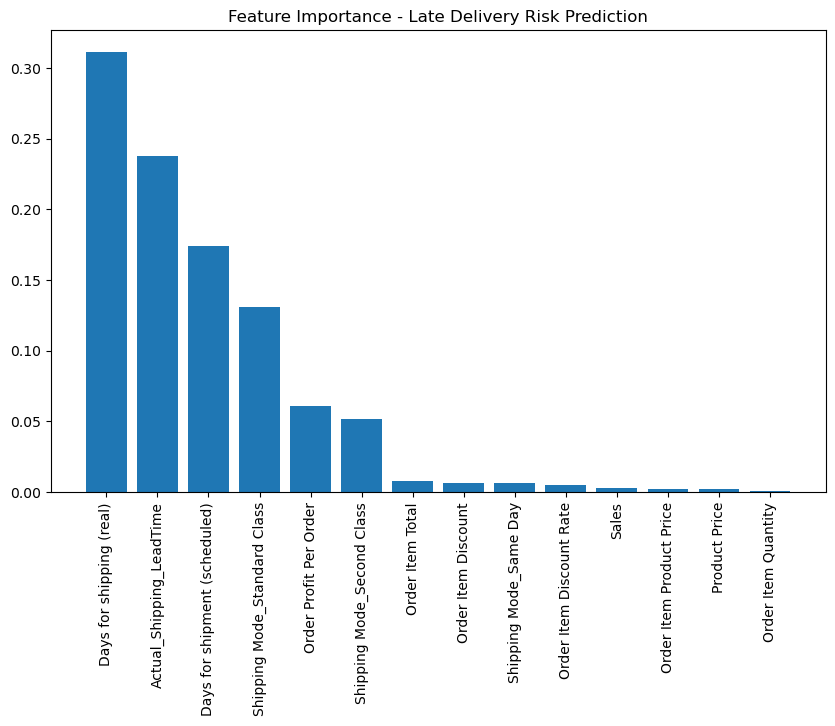

In [16]:
import numpy as np

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance - Late Delivery Risk Prediction")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.show()


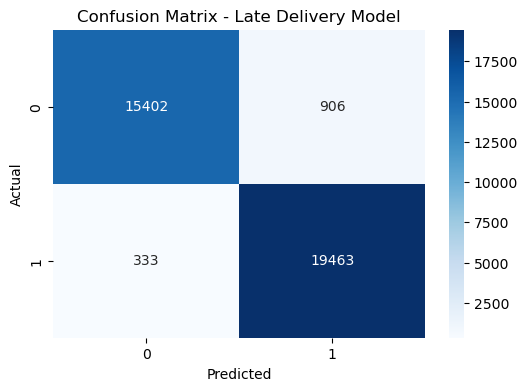

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Late Delivery Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


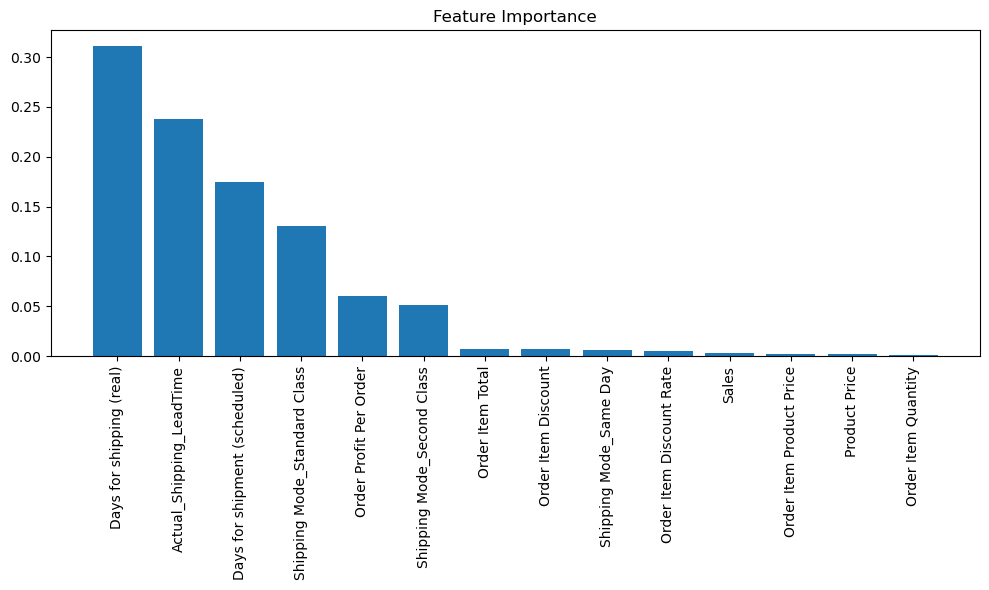

In [18]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
plt.tight_layout()
plt.savefig("visuals/feature_importance.png", dpi=300)
plt.show()


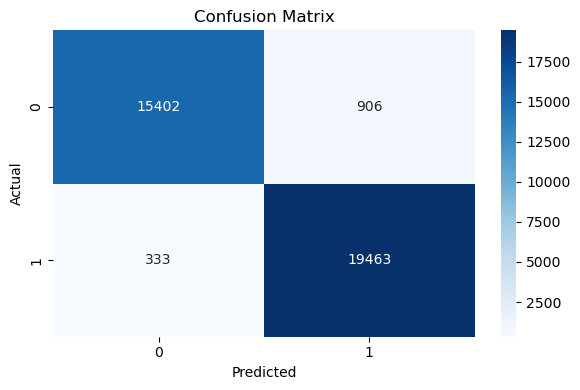

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("visuals/confusion_matrix.png", dpi=300)
plt.show()
